In [1]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
from scipy.ndimage.interpolation import shift
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.optimize import newton
import peakutils
import cv2
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import plotly
plotly.offline.init_notebook_mode()
import plotly.plotly as py
from plotly.offline import iplot,plot
import plotly.graph_objs as go
import time
import re
import math
import seaborn as sns

from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
import heapq
%matplotlib inline


/afs/crc.nd.edu/user/j/jlai1/.local/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


In [2]:
start_time = time.time()
engine = create_engine('sqlite+pysqlite:///../../data/SQL/10C/85_8.db')
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
end_time = time.time()
print end_time-start_time

engine = create_engine('sqlite+pysqlite:///../../data/SQL/10C/ProtoMap.db')
ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
print ProtoMapdf.head()

139.81916213
   PadNum        PadName     PadX      PadY  BinNum
0       0  sector_center  0.00000  0.000000     257
1       1      sector1_0  1.30108  0.947523       1
2       2      sector2_0  2.18496  1.831410       2
3       3      sector1_1  2.71529  2.361740       3
4       4      sector2_1  3.59917  3.245620       4


In [3]:
start_time = time.time()
ADCdf.columns = [np.uint16(_[1:]) if re.match('t\d+',_) is not None else _ for _ in ADCdf.columns ]
ADCdf['max'] = ADCdf.iloc[:,3+50:-50].max(axis=1)
mask= (ADCdf.iloc[:,3:-1]>20) & (ADCdf.iloc[:,3:-1].gt(ADCdf['max']*0.2,axis=0))
ADCdf.iloc[:,3:-1] = ADCdf.iloc[:,3:-1][mask].fillna(0)
end_time = time.time()
print end_time-start_time

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/indexes/base.py:1396: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/indexes/base.py:2134: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



14.1907060146


In [4]:
start_time = time.time()
n1 = [_ for _ in ADCdf.columns if type(_) is np.uint16]
n2 = [_ for _ in ADCdf.columns if type(_) is not np.uint16]
t2 = pd.melt(ADCdf.iloc[:],id_vars=n2,value_vars=n1).drop(['ID'],axis=1)
t2.columns = ['EventID','PadNum','max','time','charge']
t3 = pd.merge(t2[t2['charge']>20],ProtoMapdf,on='PadNum')[['EventID','PadNum','time','PadX','PadY','charge']]
print time.time() - start_time

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/indexes/base.py:1100: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal

/afs/crc.nd.edu/user/j/jlai1/.local/usr/share/anaconda2/lib/python2.7/site-packages/pandas/indexes/base.py:2286: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



33.0803940296


In [33]:
-

/afs/crc.nd.edu/user/j/jlai1/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



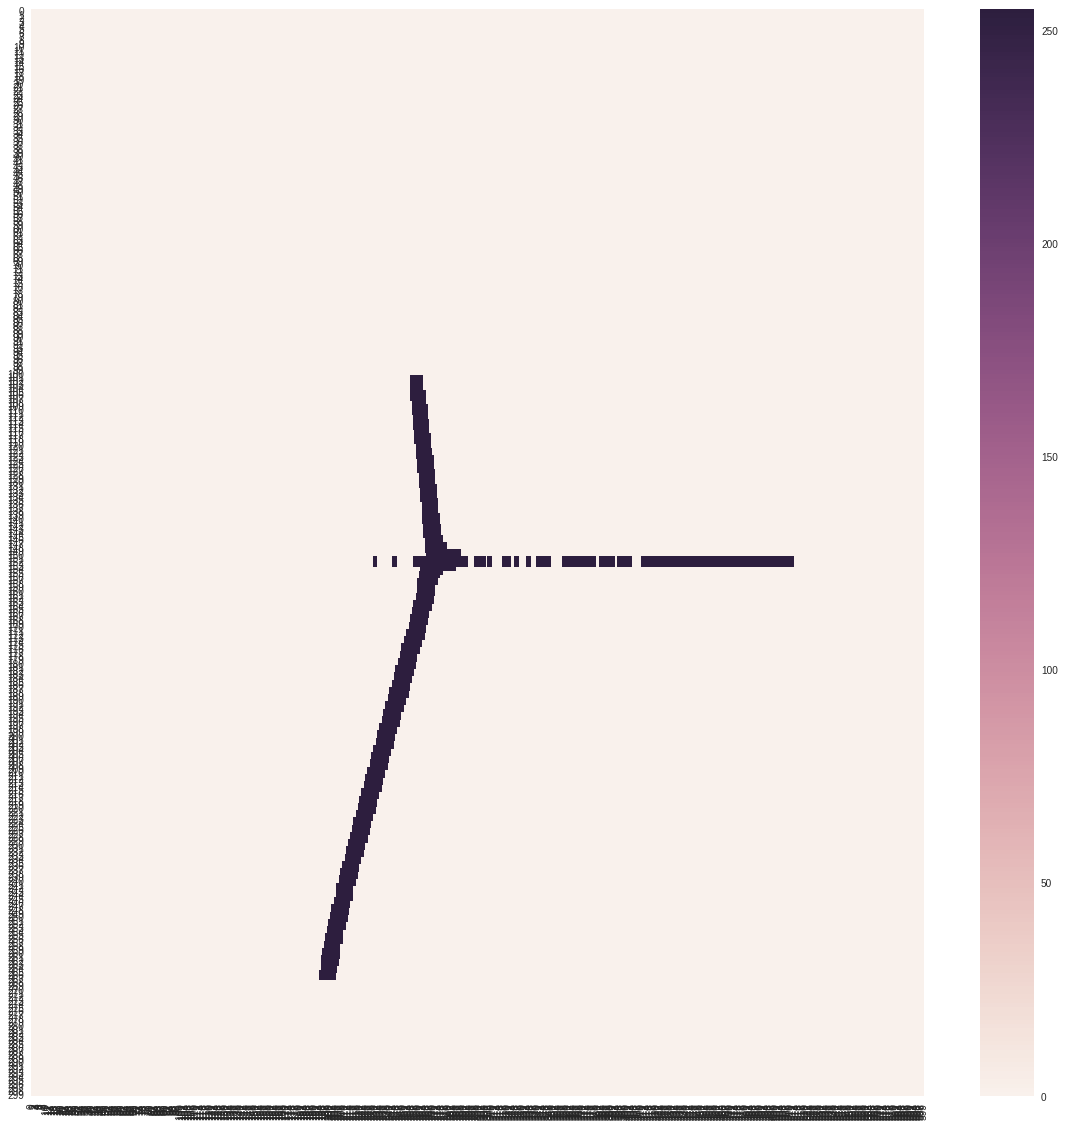

In [35]:
plt.figure(figsize=(20,20))
pic = Process(233)
sns.heatmap(pic[::-1])

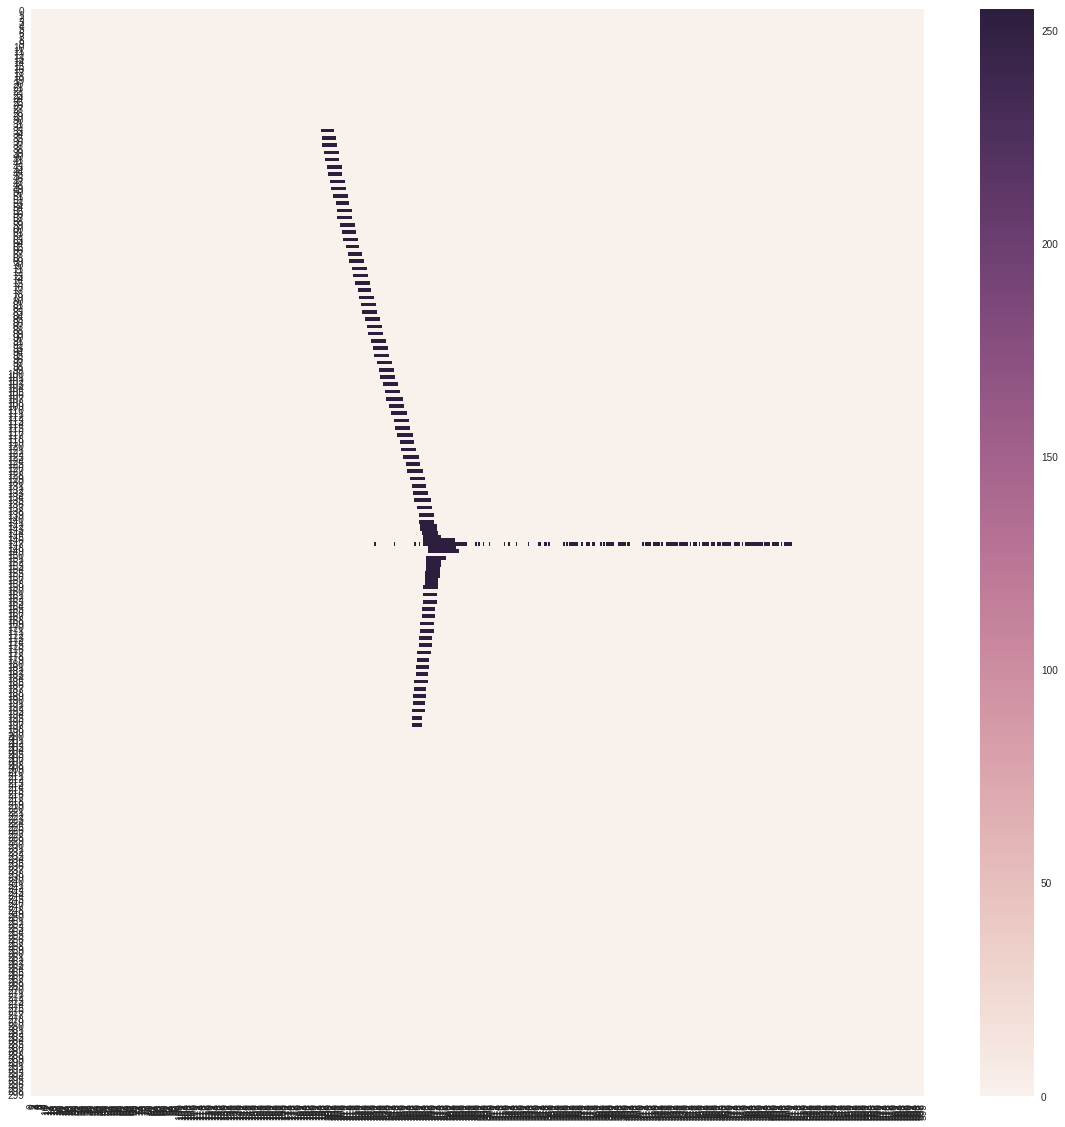

In [39]:
plt.figure(figsize=(20,20))

sns.heatmap(image2)

In [55]:
EID = 233
tmp = t3[(t3['EventID']==EID)&(t3['charge']>3)]
p = (tmp['PadNum']-1)%63+1

tmp['PadPos'] = ((p-9)*(p>9)+p)*(tmp['PadNum']!=0)

Q1 = tmp[(tmp['PadX']>0)&(tmp['PadY']>0)]
Q2 = tmp[(tmp['PadX']<0)&(tmp['PadY']>0)]
Q3 = tmp[(tmp['PadX']<0)&(tmp['PadY']<0)]
Q4 = tmp[(tmp['PadX']>0)&(tmp['PadY']<0)]


image1 = np.zeros([300,600])
image1[(Q1['PadPos'].values+150).astype(np.int), Q1['time'].values.astype(np.int)] =255

image2 = np.zeros([300,600])
image2[(Q3['PadPos'].values+150).astype(np.int), Q3['time'].values.astype(np.int)] =255

image3 = np.zeros([300,600])
image3[(Q2['PadPos'].values+150).astype(np.int), Q2['time'].values.astype(np.int)] =255

image4 = np.zeros([300,600])
image4[(Q4['PadPos'].values+150).astype(np.int), Q4['time'].values.astype(np.int)] =255

/afs/crc.nd.edu/user/j/jlai1/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



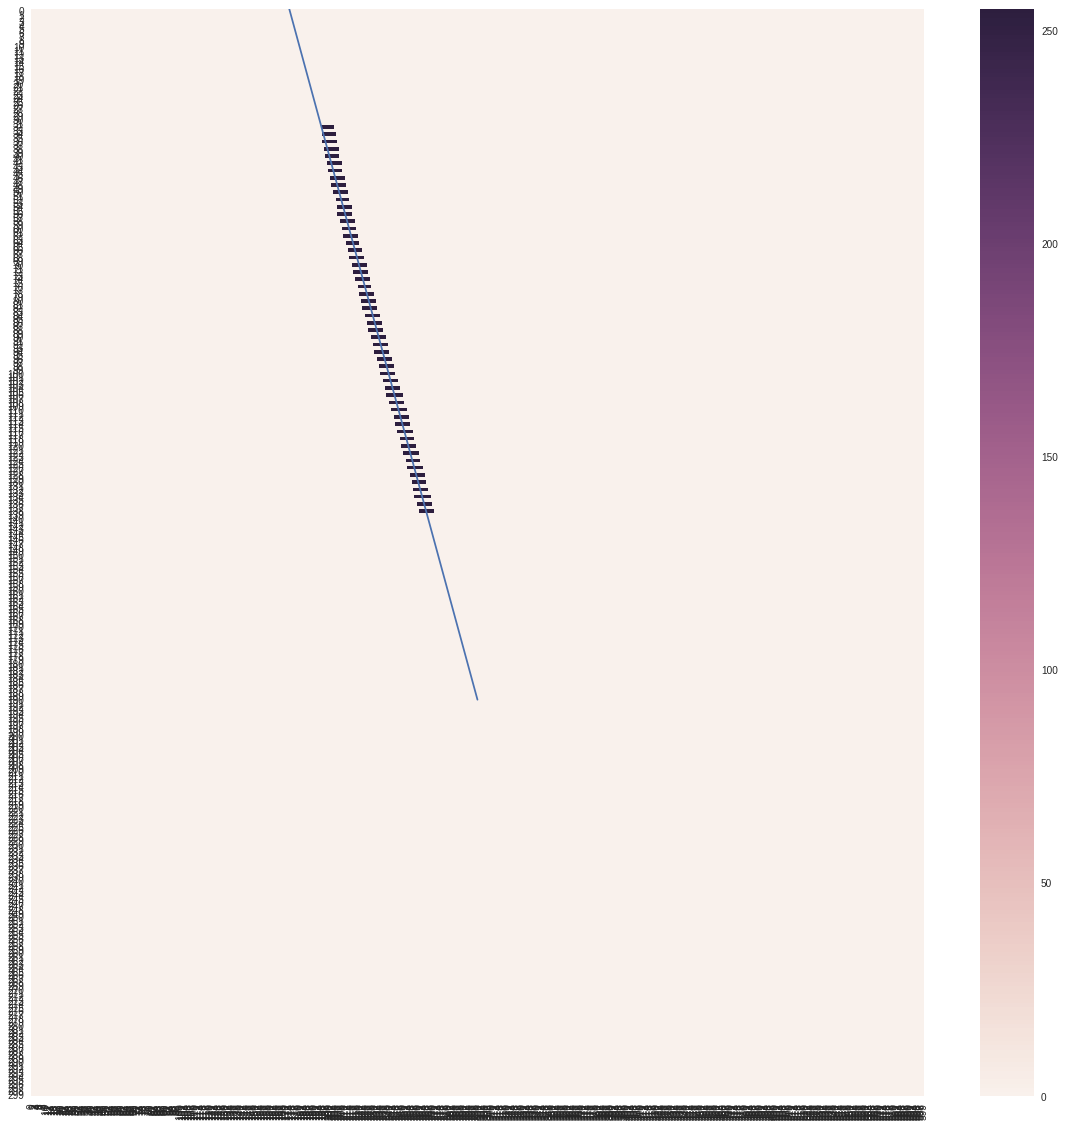

In [76]:
image = np.zeros([300,600])
Q = Q2[Q2['PadPos'].abs()>10]

k,b= np.polyfit(Q['time'].astype(np.float),Q['PadPos'].values+150,1)

image[(Q['PadPos'].values+150).astype(np.int), Q['time'].values.astype(np.int)] =255
#plt.plot()

plt.figure(figsize=(20,20))
sns.heatmap(image[::-1])
plt.plot([0,300],[561.4283658,-1.50696312*300+ 561.4283658 ])




In [146]:
image1 = np.zeros([300,600])
image1[(-Q2['PadPos'].values+150).astype(np.int), Q2['time'].values.astype(np.int)] =255

image1[(Q4['PadPos'].values+150).astype(np.int), Q4['time'].values.astype(np.int)] =255

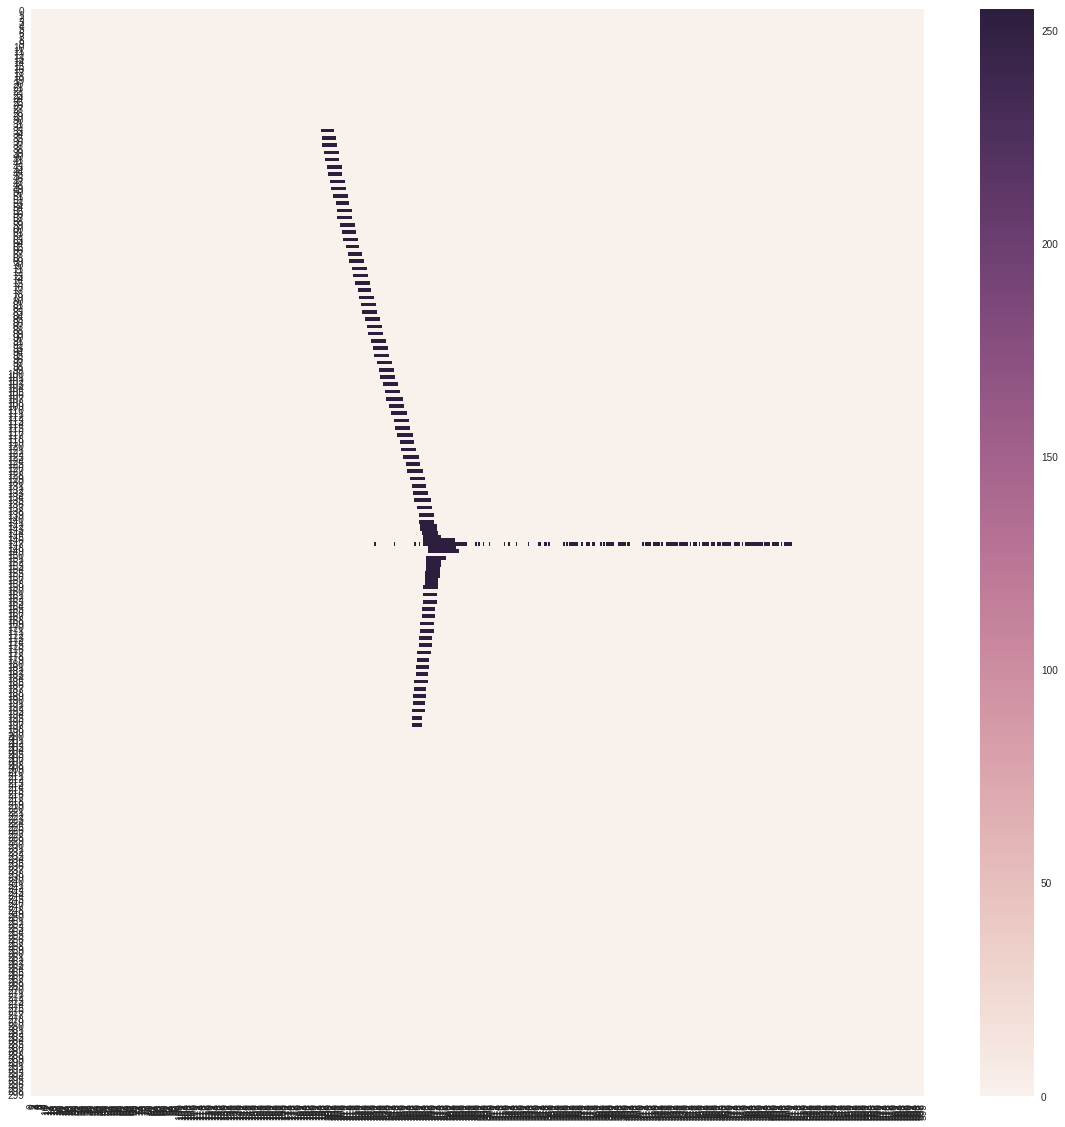

In [101]:
plt.figure(figsize=(20,20))

x0 = (150.0-b)/k
#print x0
#image1[:,:int(x0)]=0

sns.heatmap(image1)


In [108]:
x0 = (150.0-b)/k

image1[:,:int(x0)+20] = 0

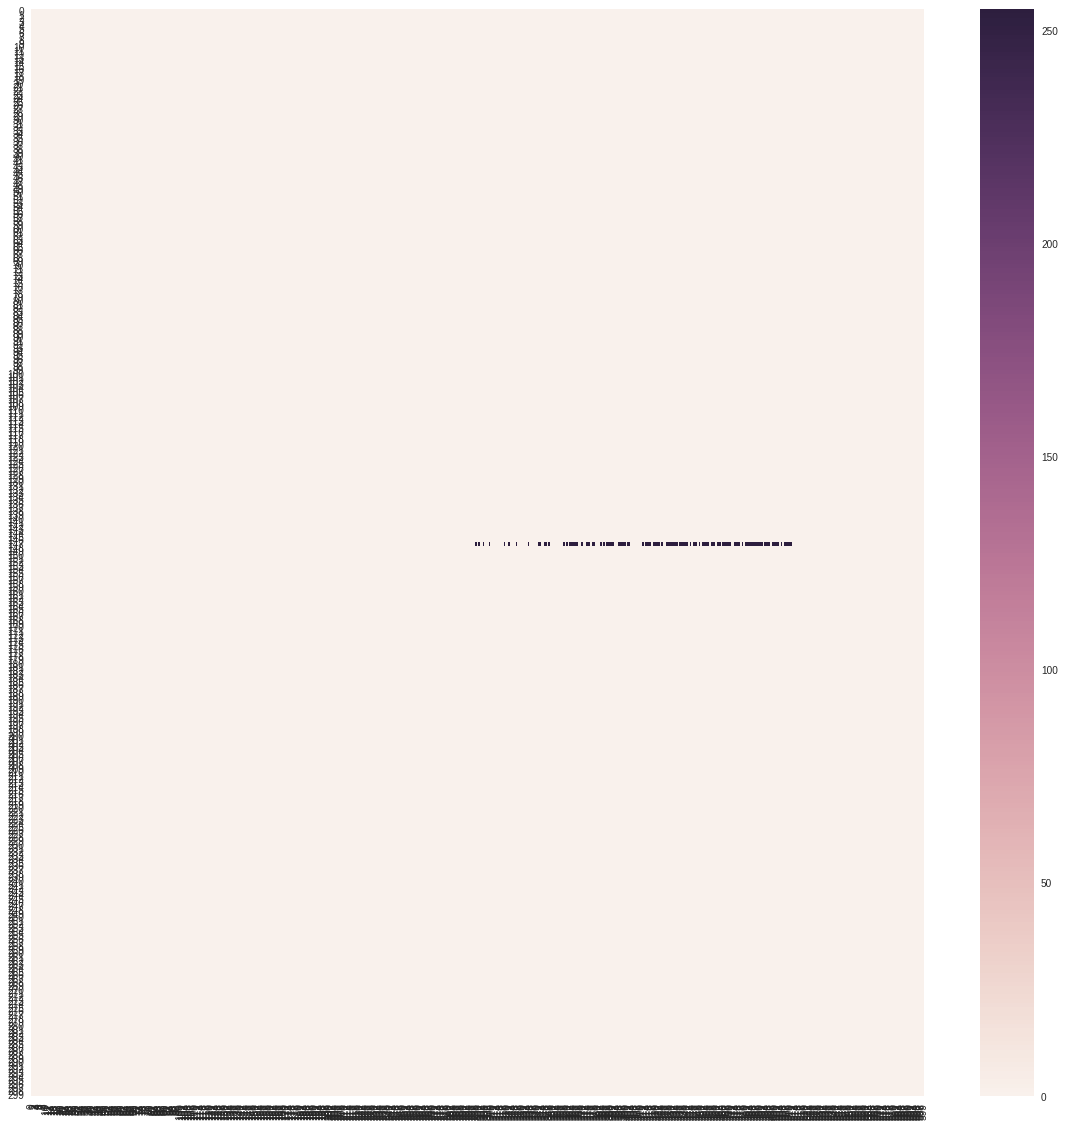

In [109]:
plt.figure(figsize=(20,20))
sns.heatmap(image1)

In [112]:
y,x= np.where(image1>20)

np.polyfit(x,y,1)

array([  9.56818296e-17,   1.47000000e+02])

In [113]:
def sigma(x,y):
    xc,yc = x.mean(), y.mean()
    x_,y_ = x-xc, y-yc
    r = np.sqrt(x_*x_+y_*y_)
    return np.std(r)
    

In [114]:
sigma(x,y)

30.224622422245599

In [130]:
image1[:150,:] = 0

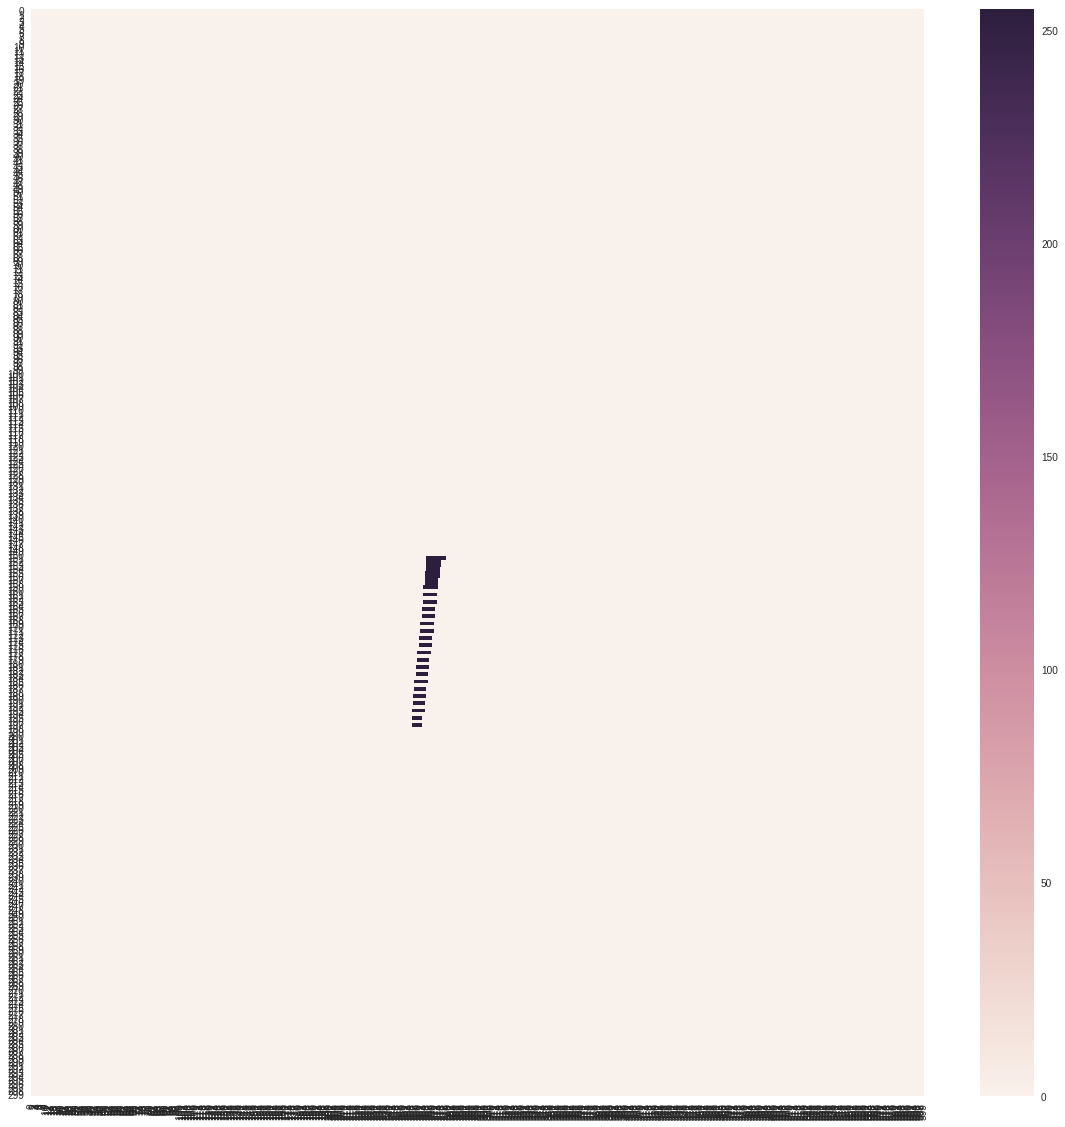

In [131]:
plt.figure(figsize=(20,20))
sns.heatmap(image1)

In [142]:
y,x= np.where(image1>20)
k3,b3 = np.polyfit(x,300-y,1)


In [143]:
print k3,b3


2.53095117938 -543.098522926


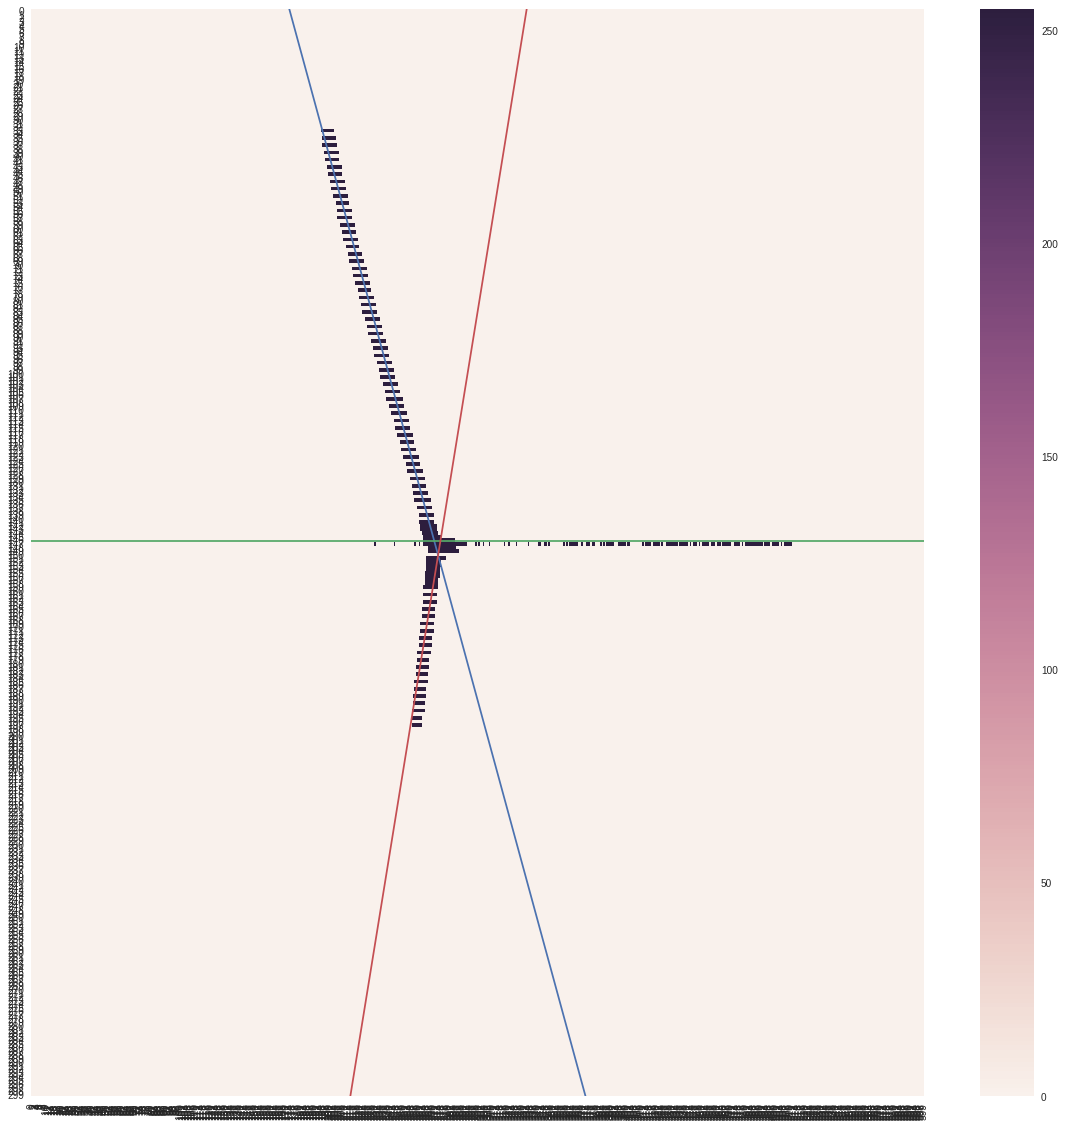

In [147]:
plt.figure(figsize=(20,20))
sns.heatmap(image1)

plt.plot([0,600],[561.4283658,-1.50696312*600+ 561.4283658 ])
plt.plot([0,600],[300-147,300-147])
plt.plot([0,600],[-543.098522926 ,2.53095117938*600 -543.098522926])
